In [1]:
import mindspore
from mindspore import nn, ops, Tensor
from mindspore.dataset import GeneratorDataset
import os

from PIL import Image
from mindspore.dataset.vision import Resize, ToTensor, Normalize
from mindspore.dataset.transforms import Compose
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display 
from network import Siren
from data_processor import ImagesINR, get_images_as_tensor, get_input_coords, rescale_image_array, decode_output_tensor

/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


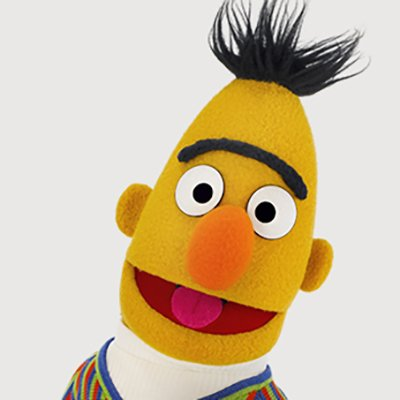

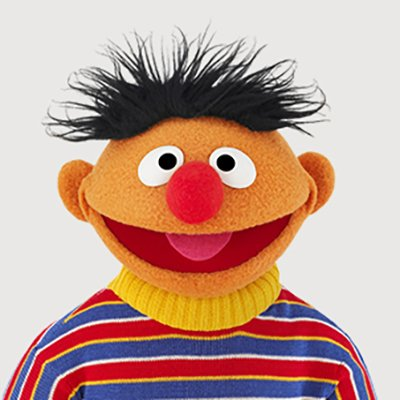

In [2]:
first_img = Image.open('./samples/bert.jpg', 'r')
second_img = Image.open('./samples/ernie.jpg', 'r')
display(first_img)
display(second_img)

As in Siren, the pixels values are rescaled to [-1,1]. The (x,y) coords in the images are also rescaled in the [-1, 1] range. In order to deal with multiple images, an index has been added (the first image being represented by the index -1, and the second one by 1). Finally, the input to the network is now of size 3. All the coordinates will be feeded to the network in a single iteration (i.e one batch)

# Experiments

## Training with all pixels from resolution 100

In [3]:
loader = ImagesINR(100, first_img, second_img)
dataset = GeneratorDataset(source = loader, column_names = ['coords', 'pixels'])
dataset = dataset.batch(1)

In [4]:
img_siren = Siren(features=[3,512,512,512,512,512,512,512,3], outermost_linear = True)
mindspore.set_context(device_target = 'Ascend')

Step 0 / 300


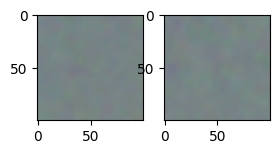

Step 25 / 300


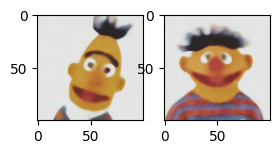

Step 50 / 300


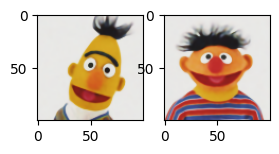

Step 75 / 300


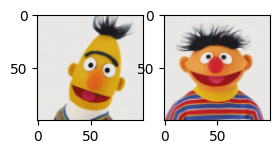

Step 100 / 300


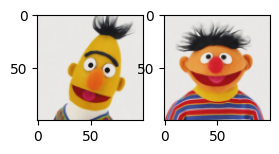

Step 125 / 300


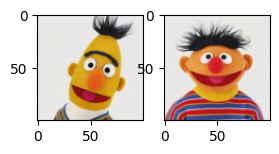

Step 150 / 300


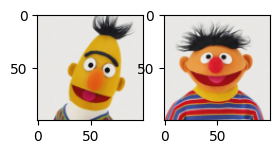

Step 175 / 300


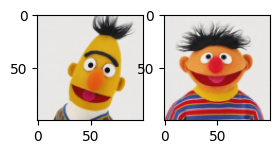

Step 200 / 300


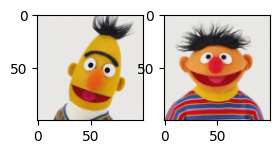

Step 225 / 300


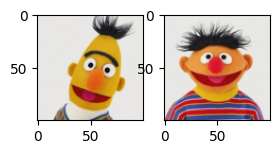

Step 250 / 300


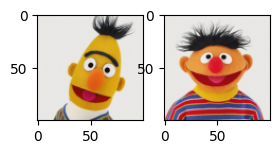

Step 275 / 300


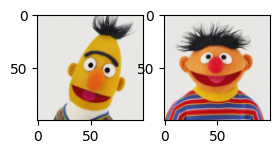

In [5]:
total_steps = 300
optim = nn.Adam(img_siren.trainable_params(), learning_rate = 1e-4)

model_input, ground_truth = next(iter(dataset.create_tuple_iterator()))

model_input = model_input.astype(mindspore.float32)
#ground_truth = ground_truth.astype(mindspore.float32)
losses = []
def forward_fn(model_input, ground_truth):
    model_output = img_siren(model_input)
    loss = ((model_output - ground_truth) ** 2).mean()
    return loss, model_output

grad_fn = mindspore.value_and_grad(forward_fn, None, optim.parameters, has_aux = True)

for step in range(total_steps):
    (loss, model_output), grads = grad_fn(model_input, ground_truth)
    losses.append(loss.asnumpy())
    
    if step % 25 == 0:
        print('Step {} / {}'.format(step, total_steps))
        # Taking the predictions corresponding to the first image
        x1 = decode_output_tensor(model_output[0: , :10000], 100) 
        x1 = x1.astype(np.uint8)
        f, ax = plt.subplots(1, 2, figsize=(3,3))

        #Same for second image
        x2 = decode_output_tensor(model_output[0: , 10000:], 100) 
        x2 = x2.astype(np.uint8)
        ax[0].imshow(x1)
        ax[1].imshow(x2)
        plt.show()

    optim(grads)

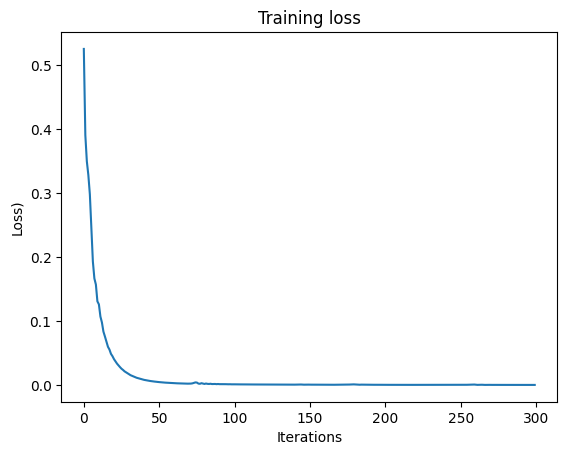

In [6]:
fig, ax = plt.subplots()
ax.plot(np.arange(total_steps), losses)

ax.set(xlabel='Iterations', ylabel='Loss)',
       title='Training loss')

plt.show()

Thus, we can see that after a few iterations, those 2 images can already be reconstructed. Details becore more accurate through epochs, as it looks like that it first learns to generate the background, then the global shape, then details. In this experiment, the network was trained with all the coords at resolution 100. Let's check in the next part what happen when using part of the pixels as validation set.

## Hiding a few pixels as Validation set - Generalization

Let's use now 20% of the pixels as a validation set.

In [7]:
img_siren = Siren(features=[3,512,512,512,512,512,512,512,3], outermost_linear = True)
mindspore.set_context(device_target = 'Ascend')

class NumpyDataset:
    def __init__(self, *numpys: np):
        self.numpys = numpys

    def __len__(self):
        return self.numpys[0].shape[0]
    
    def __getitem__(self, index):
        return tuple(n[index] for n in self.numpys)

loader_np = NumpyDataset(loader.coords, loader.pixels)
dataset_np = GeneratorDataset(source = loader_np, column_names = ['np1', 'np2'])
val_pct = 0.2
train_dset, val_dset = dataset_np.split([0.8, 0.2])
train_dset = train_dset.batch(len(train_dset))
val_dset = val_dset.batch(len(val_dset))

[WARNING] ME(38057:281472892309680,MainProcess):2025-01-02-14:15:30.218.251 [mindspore/dataset/engine/datasets.py:2506] Dataset is shuffled before split.


Step 0 / 300


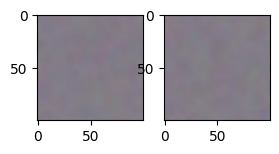

Step 25 / 300


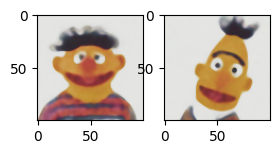

Step 50 / 300


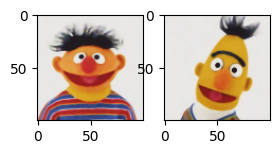

Step 75 / 300


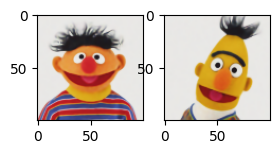

Step 100 / 300


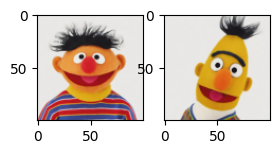

Step 125 / 300


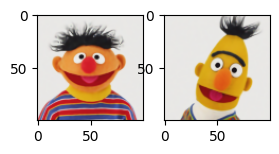

Step 150 / 300


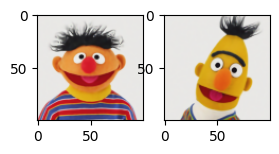

Step 175 / 300


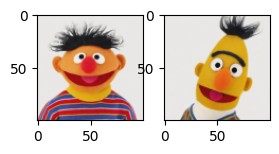

Step 200 / 300


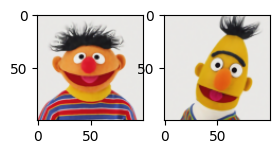

Step 225 / 300


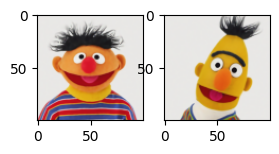

Step 250 / 300


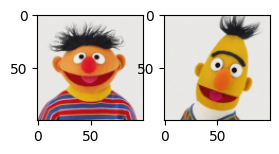

Step 275 / 300


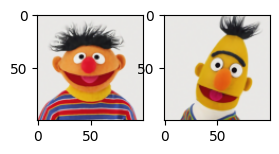

In [8]:
total_steps = 300 

optim = nn.Adam(img_siren.trainable_params(), learning_rate = 1e-4)

#getting all the data as a single batch
x_train, y_train = next(iter(train_dset.create_tuple_iterator()))
x_train = x_train.astype(mindspore.float32)
#y_train = y_train.astype(mindspore.float32)
x_val, y_val = next(iter(val_dset.create_tuple_iterator()))
x_val = x_val.astype(mindspore.float32)
#y_val = y_val.astype(mindspore.float32)

model_input, ground_truth = next(iter(dataset))
model_input = model_input.astype(mindspore.float32)
#ground_truth = ground_truth.astype(mindspore.float32)

train_losses = []
val_losses = []

def forward_fn(x_train, y_train, x_val, y_val):
    train_out = img_siren(x_train)
    loss = ((train_out - y_train) ** 2).mean()
    val_out = img_siren(x_val)
    val_loss = ((val_out - y_val) ** 2).mean()
    return loss, train_out, val_loss, val_out 

grad_fn = mindspore.value_and_grad(forward_fn, None, optim.parameters, has_aux = True)

for step in range(total_steps):
    (loss, train_out, val_loss, val_out), grads = grad_fn(x_train, y_train, x_val, y_val)

    train_losses.append(loss.asnumpy())
    val_losses.append(val_loss.asnumpy())
  
    if  step % 25 == 0:
        print('Step {} / {}'.format(step, total_steps))
        #Running the network on all the pixels to visualize the images
        model_output = img_siren(model_input)    

        # Taking the predictions corresponding to the first image
        x1 = decode_output_tensor(model_output[0: , 10000:], 100) 
        x1 = x1.astype(np.uint8)
        f, ax = plt.subplots(1, 2, figsize=(3, 3))

        #Same for second image
        x2 = decode_output_tensor(model_output[0: , :10000], 100) 
        x2 = x2.astype(np.uint8)
        ax[0].imshow(x1)
        ax[1].imshow(x2)
        plt.show()
    optim(grads)

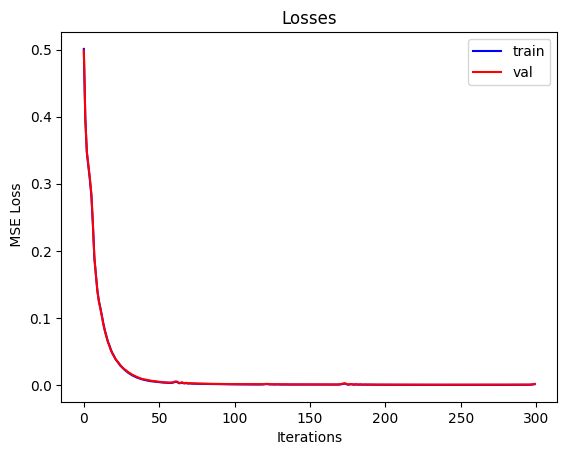

In [9]:
fig, ax = plt.subplots()
ax.plot(np.arange(total_steps), train_losses, "b", label = 'train')
ax.plot(np.arange(total_steps), val_losses, "r", label = 'val')

ax.set(xlabel = 'Iterations', ylabel = ' MSE Loss', title = 'Losses')
plt.legend(loc = 'best')
plt.show()

Thus, we can see that the network is not simply learning the pixel values for given coordinates from the training set but is able to generalize to unseen pixels from the validation set as the loss is also decreasing on this set. In this context, generalizing means being able to regress satisfying RGB values for continuous coordinates in the range [-1, 1] (including of course coordinates not in the training data) for both images. This might be use for instance for upsampling or impainting task.

However, if we have a closer look to the loss, including if the validation loss is decreasing, it remains a bit higher than the training loss:

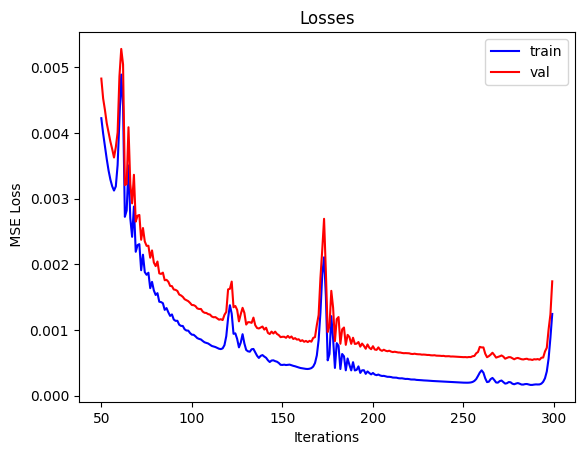

In [10]:
fig, ax = plt.subplots()
ax.plot(np.arange(50, total_steps), train_losses[50: ], "b", label = 'train')
ax.plot(np.arange(50, total_steps), val_losses[50: ], "r", label = 'val')

ax.set(xlabel = 'Iterations', ylabel = ' MSE Loss', title = 'Losses')
plt.legend(loc = 'best')
plt.show()

## Upsampling 

As we saw previously, the network is able to generalize to continuous coordinates sampled in [-1,1]. Thus getting a higher resolution image means sampling more discrete points in those continuous intervals.

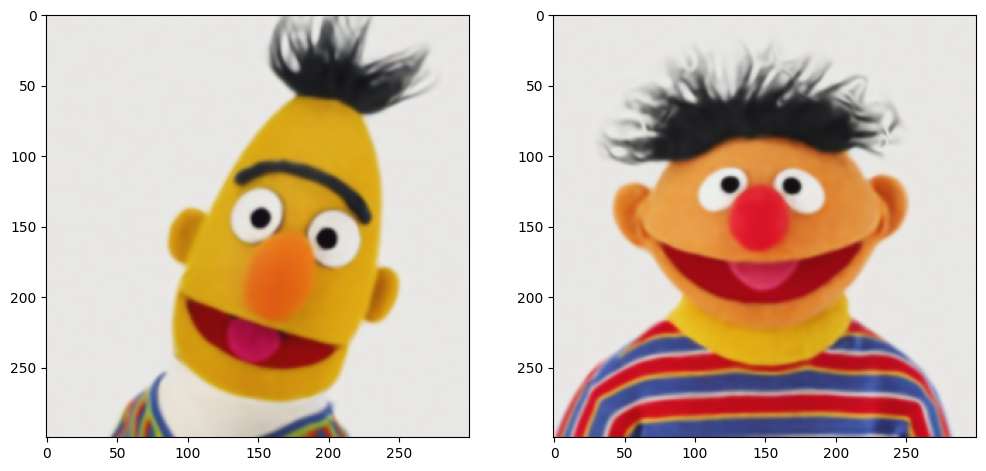

In [11]:
umpsampling_coords = get_input_coords(300, dim = 2)
f, ax = plt.subplots(1, 2, figsize = (12, 12))
mindspore.set_context(device_target = "Ascend")

model_output = img_siren(Tensor.from_numpy(umpsampling_coords[:90000]).astype(mindspore.float32))    
up_img1_dec = decode_output_tensor(model_output, 300) 
up_img1_dec = up_img1_dec.astype(np.uint8)
model_output = img_siren(Tensor.from_numpy(umpsampling_coords[90000:]).astype(mindspore.float32))    
up_img2_dec = decode_output_tensor(model_output, 300) 
up_img2_dec = up_img2_dec.astype(np.uint8)
ax[0].imshow(up_img1_dec)
ax[1].imshow(up_img2_dec)
plt.show()

Let's downscale then upscale with Bicubic interpolation the original images in order to compare with the generated ones

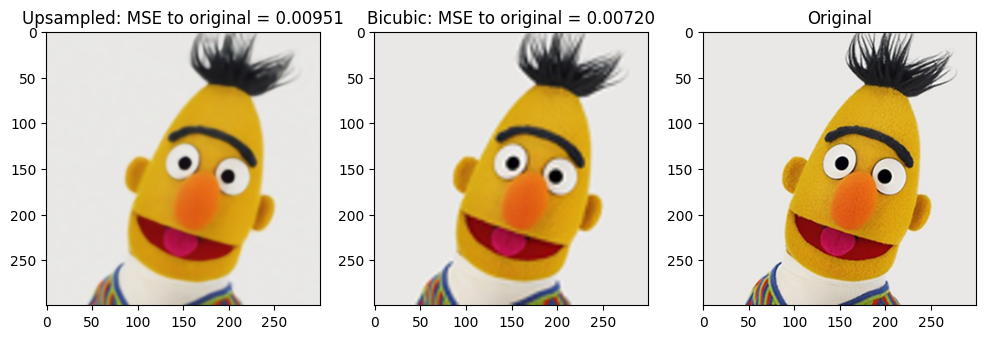

In [12]:
#reshaping original image to 300*300
original_img1 = first_img.resize((300, 300), Image.BICUBIC)
down_img1 = first_img.resize((100, 100), Image.BICUBIC)
up_img1 = down_img1.resize((300, 300), Image.BICUBIC)
f, ax = plt.subplots(1, 3, figsize = (12, 12))

mse_upsampled = np.mean((rescale_image_array(up_img1_dec) - rescale_image_array(np.asarray(original_img1)))**2)
mse_bicubic = np.mean((rescale_image_array(np.asarray(up_img1)) - rescale_image_array(np.asarray(original_img1)))**2)

ax[0].imshow(up_img1_dec)
ax[0].set_title('Upsampled: MSE to original = {:.5f}'.format(mse_upsampled))
ax[1].imshow(up_img1)
ax[1].set_title('Bicubic: MSE to original = {:.5f}'.format(mse_bicubic))
ax[2].imshow(original_img1)
ax[2].set_title('Original')

plt.show()

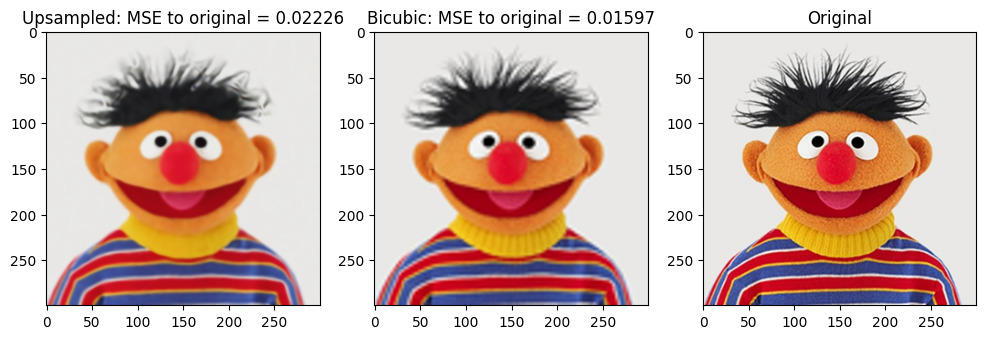

In [13]:
original_img2 = second_img.resize((300, 300), Image.BICUBIC)

down_img2 = second_img.resize((100, 100), Image.BICUBIC)
up_img2 = down_img2.resize((300, 300), Image.BICUBIC)
f, ax = plt.subplots(1, 3, figsize = (12, 12))

mse_upsampled = np.mean((rescale_image_array(up_img2_dec) - rescale_image_array(np.asarray(original_img2)))**2)
mse_bicubic = np.mean((rescale_image_array(np.asarray(up_img2)) - rescale_image_array(np.asarray(original_img2)))**2)

ax[0].imshow(up_img2_dec)
ax[0].set_title('Upsampled: MSE to original = {:.5f}'.format(mse_upsampled))
ax[1].imshow(up_img2)
ax[1].set_title('Bicubic: MSE to original = {:.5f}'.format(mse_bicubic))
ax[2].imshow(original_img2)
ax[2].set_title('Original')

plt.show()

Thus, this method is providing with satisfying upsampling results visually. However, it gets an higher MSE than a traditional method such as a bicubic interpolation (when downsampling to a 100*100 image and then upsampling).